In [1]:
#establishing environment
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy
from scipy.stats import pearsonr
from scipy import signal as sig
from scipy.io import loadmat, savemat
!pip install git+https://github.com/ieeg-portal/ieegpy.git # Install ieegpy toolbox directly from github
from ieeg.auth import Session

  Cloning https://github.com/ieeg-portal/ieegpy.git to /private/var/folders/j3/ps9_bddj0kg0ds3px8t769_00000gn/T/pip-req-build-70ocbgzv
  Running command git clone -q https://github.com/ieeg-portal/ieegpy.git /private/var/folders/j3/ps9_bddj0kg0ds3px8t769_00000gn/T/pip-req-build-70ocbgzv
  Resolved https://github.com/ieeg-portal/ieegpy.git to commit 080bfa42a8503380ef164b5e7b116613f75073bb


In [2]:
split_HUP203 = loadmat('/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/Results_v1/split_HUP203_phaseII.mat'); #local machine save #this is 10 gdfs
#new mat file is trimmed down amount of values. drop many of the channels and only imported the 0.5s's before and after a spike for every spike in every sequence.

In [3]:
#open the binary file and use its content to create a session frmo IEEG
with open('/Users/carlosaguila/Documents/BE521/agu_ieeglogin.bin', 'r') as f:
    session = Session('aguilac', f.read())
#get the specified dataset from IEEG
dataset = session.open_dataset('HUP203_phaseII')
chlabels = dataset.get_channel_labels()
timeseries1 = dataset.get_time_series_details(chlabels[0])
fs= timeseries1.sample_rate

In [4]:
#structure split into it's respective fields
split = split_HUP203
#fs = 512; this is the fs for HUP203, but you can just use IEEG session in cell above
chLabels = np.transpose(split['chLabels'])
values = np.transpose(split['values'])
seqs = np.transpose(split['sequences'])
leaders = np.transpose(split['leaders'])
global_coi = np.transpose(split['global_coi'])

In [5]:
#use % operator to have the same functionality as sprintf (link: https://stackoverflow.com/questions/5309978/sprintf-like-functionality-in-python )

In [7]:
#concatenates each sequence to form a GDF -- removes the sequences in each runtime
def concat_seqs(I):
    if seqs[I,0].size != 0:
        X = np.concatenate(np.concatenate(seqs[I,0]))
    else:
        X = []
    return X #recreates the GDF from which the sequence was parsed - I can be used to iterate through the whole code

In [9]:
#will apply concat_seqs to all sequenced runtimes we have in our split
seqs_concat = [];
for I in range(len(seqs)):
    seq_concat2 = concat_seqs(I)
    seqs_concat.append(seq_concat2)

In [227]:
#take the GDF/runtime --> find the max per ch 
#I refers to the index of the specific sequence runtime we want.
def max_per_runtime(seqs,values,I):
    seq_concat = concat_seqs(I);
    if len(seq_concat) != 0: #skip past the "no spike detected" sequence runtimes
        ch_uniq = np.unique(seq_concat[:,0])
        all_maxvals = []
        for ch in ch_uniq:
            x = np.where(seq_concat[:,0] == ch)[0] #should give you an array with positions where that unique ch was used.
            all_maxes_per_ch = []
            for x in x: #calls on each array in x --> (example. i == [10 34, 70] for when spike channel == 7)
                val = values[I,0][x] - np.mean(values[I,0][x])
                max_val = np.max(np.abs(val))
                all_maxes_per_ch.append(max_val)
            all_maxvals.append([ch, all_maxes_per_ch]) 
    else: #the ones with spikes now
        all_maxvals = []
    return all_maxvals #will return all max values in a runtime

#take the singular max calculator from above and make it run for all sequence run_times
def maxes_for_all(seqs,values):
    all_max_vals = []
    for I in range(len(values)):
        runtime_max_vals = max_per_runtime(seqs,values,I)
        all_max_vals.append(runtime_max_vals)
    return all_max_vals

In [238]:
all_max_vals = maxes_for_all(seqs,values)
print(np.shape(all_max_vals))
print(np.shape(all_max_vals[3]))

(1049,)
(61, 2)


In [247]:
print(len(chLabels[0][0]))
chlabels_idx = range(len(chLabels[0][0]))
print(chlabels_idx)
chlabels_idx = [x+1 for x in chlabels_idx] #moved to matlab indices so that it corresponds to channel numbers HAVE TO SUBTRACT ONE FOR THE PYTHON INDEX
#use np.where to then cycle through all iterations to match maxes to long list of channels vs. maxes

146
range(0, 146)


In [264]:
print(all_max_vals[3])

[[7, [429.37959473754034]], [8, [627.238289663003]], [35, [231.49527877585322, 220.13342186730108, 128.86964710123442]], [36, [91.33383562905581, 174.50225085568383, 151.48178798467646, 139.8838256841025, 134.13123508828426]], [37, [139.82966607325565, 209.78798872637537, 166.4505041851887, 145.88462110080764, 225.87450446545708, 221.25899336200845, 222.15939215341706, 174.00988391538752, 95.72476461070649]], [39, [260.6372636001312, 165.59416720359886, 198.17984898055414, 259.2295801034916, 153.8618640160016]], [40, [202.3305057094012, 140.08810293720256, 177.61844115889343, 248.09579869193055]], [42, [138.5326272371133, 143.04786684747188, 133.8965913905569, 116.28832564902162]], [46, [418.59731326748636, 854.3642888137581, 479.12210744196415, 912.4127048005835, 463.05232129968476, 1235.2473863271193]], [47, [1001.5857939972103, 647.794267126476, 475.80634224242135]], [48, [168.36076740784114, 345.8652303297548, 402.05503080280766]], [49, [116.57707258734635, 208.05233016616285, 175.

In [323]:
def create_single_matrix(all_max_vals):
    new_mat = []
    for i in range(len(all_max_vals)):
       for k in range(len(all_max_vals[i])):
           a = all_max_vals[i][k]
           new_mat.append(a)
    return new_mat

def create_uniqch(all_max_vals,chlabels):
    new_mat = create_matrix(all_max_vals)
    ch_id = range(len(chLabels[0][0]))
    ch_id = (x+1 for x in ch_id)
    total_maxes = []
    total_maxes_fin = []
    for ch in ch_id:
        ch_maxes = []
        for i in range(len(new_mat)):
            if new_mat[i][0] == ch:
                x = new_mat[i][1]
                ch_maxes.append(x)
        total_maxes.append(ch_maxes)
        
    for chX in total_maxes:
        if len(chX) != 0:
            x = np.concatenate(chX)
            total_maxes_fin.append(x)
        else:
            total_maxes_fin.append([])
        
    return total_maxes_fin

In [324]:
total_maxes = create_uniqch(all_max_vals,chLabels)

In [342]:
total_maxes2 = [np.mean(x) for x in total_maxes]
print(total_maxes2)

[nan, nan, nan, nan, nan, nan, 591.6279649408422, 552.8692812076367, 491.2035815688879, 335.37673877668016, 331.03633970526226, 282.54984043737824, 289.99939151995613, 260.2712310417868, 306.46703315518107, 315.5654574125634, 241.43760101272468, 141.0838549650391, 187.16961328465882, 151.3491432818871, 152.98458587000954, 212.77670655865026, 155.10739574791143, 396.9924448046104, 197.2509681788634, 175.53742753935592, 243.28664603536012, 321.9176073494062, 291.73796358820647, 126.38438724830509, 125.47269304418556, 125.67296646870618, nan, 272.34744676459127, 209.43521257753997, 194.21022324486492, 243.43179949445334, 194.87072087469429, 326.21927418517765, 307.25747536446994, 202.28021416552818, 200.1079011011, 305.6966215015243, 352.00239354114484, 358.3896320418374, 711.5272964565746, 924.4952341697522, 573.7304586675822, 319.6850998896332, 389.0749527186525, 270.71643123547096, 268.49058024964285, 173.29705739039665, 194.17763640681198, 171.01997508611316, 170.48373549294448, 167.9

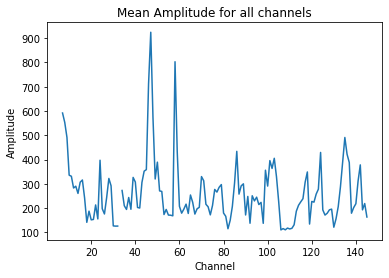

In [362]:
chlabels_idx = range(len(chLabels[0][0]))
chlabels_idx = [x+1 for x in chlabels_idx]
plt.plot(chlabels_idx,total_maxes2)
plt.title('Mean Amplitude for all channels')
plt.xlabel('Channel')
plt.ylabel('Amplitude')
plt.show()

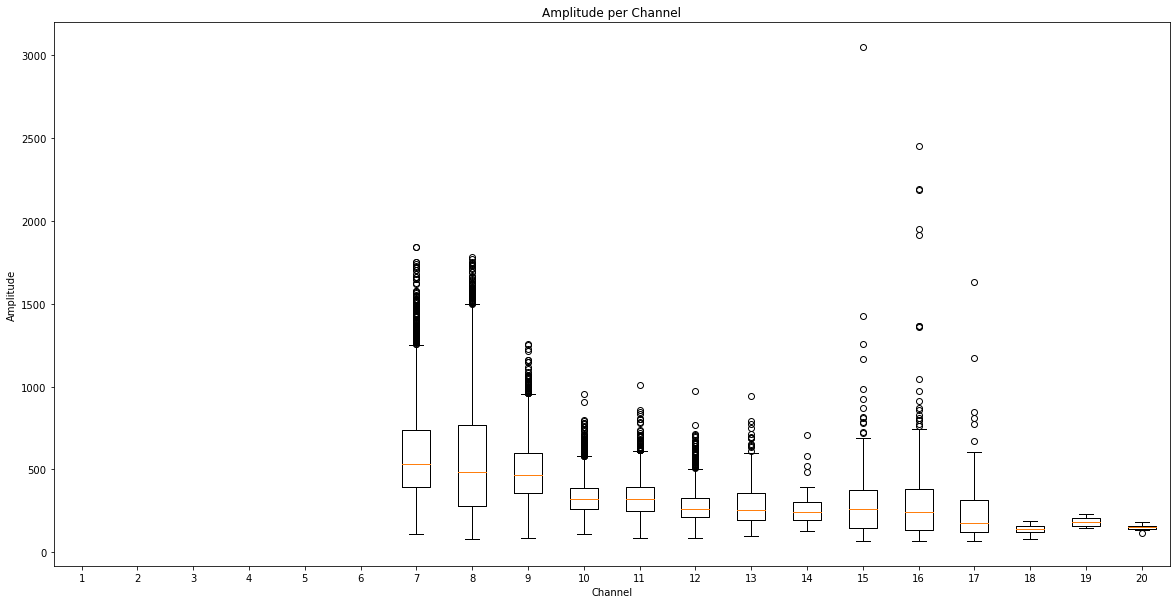

In [363]:
plt.figure(figsize=(20,10))
plt.boxplot(total_maxes[0:20]);
plt.title('Amplitude per Channel')
plt.xlabel('Channel')
plt.ylabel('Amplitude')
plt.show()

---

So now with all_max_vals, we have all the max values for each instance of a spike for all channels that were deemed to be in a sequence, in each run time.
- since analysis will be on the more macro scale - the sequences were split
    - Perhaps you can find the sequence things are a part of by calling on the original seqs and finding lengths.

max_per_runtime - First code finds the max value at each channel in a given runtime
maxes_for_all - expands max_per_runtime to every runtime in the split.


Notes:
- Each channel was baselined by its own mean *not excluding the spike* such that you get a p2 - b2, p2 - b2, ...
    - This allows us to get the absolute max value in each epoch.

---

Next step:
filter out channels that could potentially be artifact - maybe if they have less then 2-3 pings then maybe they are artifact (this will have to take into account all runtimes)
running a statistical test to find out if the SOZ channels have a larger max value than those that arent SOZ channels - this will probably look like a paired t-test type of deal

Think of Plots:
- graph that shows SOZ vs nonSOZ channels and their 1 feature across patients. 
    - Average SOZ max per channel---- seperated into SOZ vs. nonSOZ channels. plot those.
    - Find a statistic based on that^^^^
    
 
QUESTIONS:
   - AES
   - HUP 119 - has no 'data' field - ask if i can just skip that one -- can be skipped
  
   